1.Submit a Google Colab notebook containing your completed code and experimentation results.

2.Include comments and explanations in your code to help understand the implemented logic.

**Additional Notes:**
*   Ensure that the notebook runs successfully in Google Colab.
*   Document any issues encountered during experimentation and how you addressed them.

**Grading:**
*   Each task will be graded out of the specified points.
*   Points will be awarded for correctness, clarity of code, thorough experimentation, and insightful analysis.

In [1]:
from google.colab import drive
# drive.mount('/content/gdrive')

SOURCE_DIR = '/content/Q3_data.csv'

In [2]:

import torch
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import math
from gensim.models import Word2Vec

In [3]:
def delete_hashtag_usernames(text):
  try:
    result = []
    for word in text.split():
      if word[0] not in ['@', '#']:
        result.append(word)
    return ' '.join(result)
  except:
    return ''

def delete_url(text):
  text = re.sub(r'http\S+', '', text)
  return text

def delete_ex(text):
  text = re.sub(r'\u200c', '', text)
  return text

# 0. Data preprocessing

In [4]:
# 1. extract all tweets from file and save them in memory
data = pd.read_csv(SOURCE_DIR)
data.head()

,Unnamed: 0,Datetime,Text,PureText,Language,Sentiment,Date
0,0,2022-09-22 09:14:35+00:00,بنشین تا شود نقش فال ما \nنقش هم‌ فردا شدن\n#م...,بنشین تا شود نقش فال ما نقش هم‌ فردا شدن,fa,negative,2022-09-22
1,1,2022-10-06 01:44:55+00:00,@Tanasoli_Return @dr_moosavi این گوزو رو کی گر...,این گوزو رو کی گردن میگیره؟؟ دچار زوال عقل شده...,fa,very negative,2022-10-06
2,2,2022-09-22 15:12:28+00:00,@ghazaleghaffary برای ایران، برای مهسا.\n#OpIr...,برای ایران، برای مهسا.,fa,positive,2022-09-22
3,3,2022-09-22 09:35:50+00:00,@_hidden_ocean مرگ بر دیکتاتور \n#OpIran \n#Ma...,مرگ بر دیکتاتور,fa,very negative,2022-09-22
4,4,2022-09-22 01:31:25+00:00,نذاریم خونشون پایمال شه.‌‌.‌‌.\n#Mahsa_Amini #...,نذاریم خونشون پایمال شه.‌‌.‌‌.,fa,negative,2022-09-22


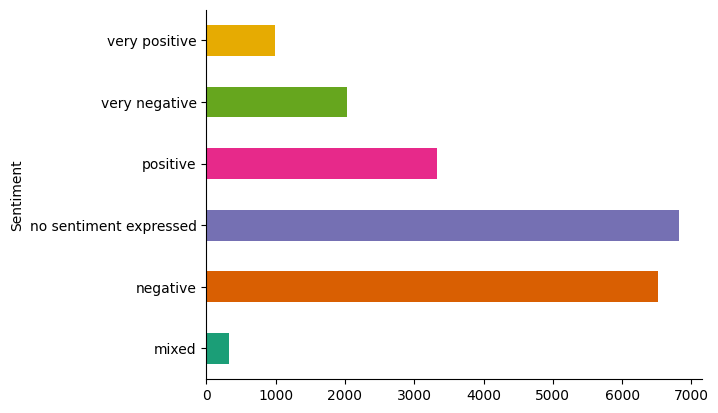

In [5]:
# @title Sentiment

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
text_data = data['Text']
text_data.head()

0    بنشین تا شود نقش فال ما \nنقش هم‌ فردا شدن\n#م...
1    @Tanasoli_Return @dr_moosavi این گوزو رو کی گر...
2    @ghazaleghaffary برای ایران، برای مهسا.\n#OpIr...
3    @_hidden_ocean مرگ بر دیکتاتور \n#OpIran \n#Ma...
4    نذاریم خونشون پایمال شه.‌‌.‌‌.\n#Mahsa_Amini #...
Name: Text, dtype: object

In [7]:
# 2. remove urls, hashtags and usernames. use the prepared functions
for i in range(len(text_data)):
  text_data[i] = delete_ex(delete_url(delete_hashtag_usernames(text_data[i])))

Streaming output truncated to the last 5000 lines.
<ipython-input-7-8c7da2209cb7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data[i] = delete_ex(delete_url(delete_hashtag_usernames(text_data[i])))
<ipython-input-7-8c7da2209cb7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data[i] = delete_ex(delete_url(delete_hashtag_usernames(text_data[i])))
<ipython-input-7-8c7da2209cb7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [8]:
text_data.head()

0              بنشین تا شود نقش فال ما نقش هم فردا شدن
1    این گوزو رو کی گردن میگیره؟؟ دچار زوال عقل شده...
2                               برای ایران، برای مهسا.
3                                      مرگ بر دیکتاتور
4                           نذاریم خونشون پایمال شه...
Name: Text, dtype: object

In [9]:
num_corr = sum(text_data==data['PureText'])
print(f"Accuracy = {num_corr / len(data['PureText'])}")

Accuracy = 0.9008


# 1. Functions

## Cosine Similarity

To measure the similarity between two words, you need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows:

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

* $u \cdot v$ is the dot product (or inner product) of two vectors
* $||u||_2$ is the norm (or length) of the vector $u$
* $\theta$ is the angle between $u$ and $v$.
* The cosine similarity depends on the angle between $u$ and $v$.
    * If $u$ and $v$ are very similar, their cosine similarity will be close to 1.
    * If they are dissimilar, the cosine similarity will take a smaller value.

<img src="images/cosine_sim.png" style="width:800px;height:250px;">
<caption><center><font color='purple'><b>Figure 1</b>: The cosine of the angle between two vectors is a measure of their similarity.</font></center></caption>

Implement the function `cosine_similarity()` to evaluate the similarity between word vectors.

**Reminder**: The norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$

In [10]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similarity between u and v

    Arguments:
        u -- a word vector of shape (n,)
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    dot = np.dot(u, v.T)
    normu = np.linalg.norm(u)
    normv = np.linalg.norm(v)
    cos = dot/np.dot(normv, normu)
    return cos

## find k nearest neighbors

In [11]:
def find_k_nearest_neighbors(word, embedding_dict, k):
  """
    implement a function to return the nearest words to an specific word based on the given dictionary

    Arguments:
        word           -- a word, string
        embedding_dict -- dictionary that maps words to their corresponding vectors
        k              -- the number of word that should be returned

    Returns:
        a list of size k consisting of the k most similar words to the given word

    Note: use the cosine_similarity function that you have implemented to calculate the similarity between words
    """
    # Initialize an empty list to store the similarities
  similarities = []

  # Get the vector of the given word
  word_vector = embedding_dict[word].reshape(1, -1)
  # Iterate over all words in the dictionary
  for key, value in embedding_dict.items():
      if key != word:
          # Calculate the cosine similarity between the given word and the current word
          similarity = cosine_similarity(word_vector, value.reshape(1, -1))

          # Append a tuple of (word, similarity) to the list
          similarities.append((key, similarity))

  # Sort the list in descending order of similarity
  similarities.sort(key=lambda x: x[1], reverse=True)

  # Get the top k words
  top_k_words = [word for word, similarity in similarities[:k]]

  return top_k_words


# 2. One hot encoding

**Vocab set**

In [12]:
vocab = list(set(word for sentence in text_data for word in sentence.split()))
vocab[:5]

['دهی.', 'لاک', 'حرکت', 'ایتالیا', 'میزدن،']

In [ ]:
# 1. find one hot encoding of each word

one_hot = np.zeros((len(vocab), len(vocab)))
for i in range(len(vocab)):
  one_hot[i][i] = 1

print(len(one_hot))
print(len(vocab))

vocab_one_hot_dict = dict(zip(vocab, one_hot))
for i, (word, one_hot_vector) in enumerate(vocab_one_hot_dict.items()):
    if i >= 5:
        break
    print(f"word: {word}, one_hot: {one_hot_vector}")

32115
32115
word: دقیق/, one_hot: [1. 0. 0. ... 0. 0. 0.]
word: میگائم, one_hot: [0. 1. 0. ... 0. 0. 0.]
word: تلفنهای, one_hot: [0. 0. 1. ... 0. 0. 0.]
word: عههههه, one_hot: [0. 0. 0. ... 0. 0. 0.]
word: خودداری, one_hot: [0. 0. 0. ... 0. 0. 0.]


In [ ]:
for i in range(len(one_hot)):
  if (vocab_one_hot_dict['آزادی'][i]==1):
    print(i)
    break
vocab_one_hot_dict['آزادی'][13278]

30166


0.0

In [ ]:
# 2. find 10 nearest words from "آزادی"
find_k_nearest_neighbors("آزادی", vocab_one_hot_dict, 10)

['دقیق/',
 'میگائم',
 'تلفنهای',
 'عههههه',
 'خودداری',
 'عشقش',
 'پدربزرگم',
 'نیستن،',
 'چیه.',
 'آدما']

##### Describe advantages and disadvantages of one-hot encoding

**Advantages** of one-hot encoding:

1. **Simplicity**: It's a simple, straightforward way to convert categorical data into a form that's usable for machine learning algorithms.
2. **Effectiveness**: It can be very effective for certain types of models, like linear models, which have difficulty dealing with categorical data directly.

**Disadvantages** of one-hot encoding:

1. **Dimensionality**: One-hot encoding can significantly increase the dimensionality of the dataset (i.e., the number of columns in the dataset). If a categorical variable has many categories, one-hot encoding will result in a dataset with a very large number of features, which can affect the performance of the machine learning model and require more memory and computational resources.
2. **Sparse Matrix**: It results in a sparse matrix where most of the values are zero. This can be an issue for certain types of models that don't handle sparse data well.
3. **Lack of Ordinal Information**: One-hot encoding treats each category as an independent variable, so it does not capture any ordinal information (order relationship) that might exist between the different categories.

# 3. TF-IDF

In [ ]:
# 1. find the TF-IDF of all tweets.
from sklearn.feature_extraction.text import TfidfVectorizer
import random

# create the Transform
matrix = []
for tweet in text_data:
  word_dict = {}
  length_of_tweet = len(tweet.split())
  for word in tweet.split():
    word_dict[word] = word_dict.get(word, 0) + 1

  for key, value in word_dict.items():
    word_dict[key] = value/length_of_tweet
  matrix.append(word_dict)

In [ ]:
np.sum(matrix[0])

{'بنشین': 0.1,
 'تا': 0.1,
 'شود': 0.1,
 'نقش': 0.2,
 'فال': 0.1,
 'ما': 0.1,
 'هم': 0.1,
 'فردا': 0.1,
 'شدن': 0.1}

In [ ]:
matrix2 = {}
for voc in vocab:
  num = 0
  for tweet in text_data:
    if voc in tweet.split():
      num +=1
  matrix2[voc] = num

In [ ]:
matrix2['تا']

998

In [ ]:
tf = np.zeros((len(vocab), len(text_data)))
for i, voc in enumerate(vocab):
  for j, word_dict in enumerate(matrix):
    tf[i][j] = word_dict.get(voc, 0)


In [ ]:
tf[0] * 3

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
tf_idf = {}
for i, voc in enumerate(vocab):
  tf_idf[voc] = tf[i] * matrix2[voc]

In [ ]:
tf_idf['تا']

array([99.8,  0. ,  0. , ...,  0. ,  0. ,  0. ])

In [ ]:
def centroid(list_of_words, tf_idf, n):  # Define a function named 'centroid' that takes a list of words, a tf-idf dictionary, and an integer 'n' as arguments.
  centroid = np.zeros((n, ))  # Initialize a numpy array of zeros with shape (n, ) to store the centroid vector.
  for word in list_of_words:  # Iterate over each word in the list of words.
    centroid += tf_idf[word]  # Add the tf-idf vector of the current word to the centroid vector.
  centroid /= len(list_of_words)  # Divide the centroid vector by the total number of words to get the average.
  return centroid  # Return the centroid vector.


In [ ]:
# 2. choose one tweets randomly.
random_text = text_data[random.randint(0, len(text_data))]

# 3. find 10 nearest tweets from chosen tweet.

list_of_words = random_text.split()  # Split the 'random_text' string into a list of words.
random_text_centroid = centroid(list_of_words, tf_idf, len(text_data))  # Calculate the centroid of 'random_text' using the 'centroid' function defined earlier.
similarity_scores = []  # Initialize an empty list to store the similarity scores.
for tweet in text_data:  # Iterate over each tweet in 'text_data'.
  if tweet != random_text:  # If the current tweet is not the same as 'random_text'.
    tweet_centroid = centroid(tweet.split(), tf_idf, len(text_data))  # Calculate the centroid of the current tweet.
    similarity_scores.append(cosine_similarity(random_text_centroid, tweet_centroid))  # Calculate the cosine similarity between the centroid of 'random_text' and the centroid of the current tweet, and append the score to 'similarity_scores'.


In [ ]:
arr = np.array(similarity_scores)
indices = arr.argsort()[-10:][::-1]
print(f"random tweet: {random_text}")
print("10 similar tweets:")
for i in indices:
  print(text_data[i])
  print('-----------------------------')

random tweet: بیزحمت فالو کنین...
10 similar tweets:
فالو شدی
-----------------------------
فالو شدی بکم بده ^^
-----------------------------
فالو شدی بک بدی
-----------------------------
منم ندارم اما حسابه خیالت راحت...😘😘🌺 بیا همو فالو کنیم😉
-----------------------------
منم فالو کنین تویت هامدیده بشن اثر گذار باشم فدای همتون🖤
-----------------------------
فالو کنین حتما بک میدم*
-----------------------------
با درود به شما ما نیز با شما هستیم به امید پیروزی و آزادی پادشاهی تنها راه نجات ایران مرسی و سپاس
-----------------------------
گسترش حضور مردم در خیابانهای تهران. هر لحظه بر جمعیت اضافه میشود فریادها رساتر از قبل... پیروزی نزدیک است... 
-----------------------------
۴۷۳ .
-----------------------------
فالو کردم:) بک میدی اکانت منم دیده بشه🙂
-----------------------------


##### Describe advantages and disadvantages of TF-IDF

**Advantages** of TF-IDF:

1. **Importance of Words**: TF-IDF weighs the words in the document, meaning it gives more importance to the words that are used less frequently. This helps in dealing with most frequent words.
2. **Down-weights Common Words**: TF-IDF naturally down-weights terms that appear frequently across documents, thus it's a good measure for identifying unique terms that can act as differentiators.
3. **Easy to Compute**: TF-IDF is simple to understand and compute.

**Disadvantages** of TF-IDF:

1. **Lack of Semantic Meaning**: TF-IDF gives you the importance of the word, but it doesn't consider the context or the semantics of the word. It fails to capture the position in text, co-occurrences in documents, and semantics associated with the word.
2. **Normalization Issue**: The main issue with TF-IDF is the normalization. The IDF is not always well scaled. A word that appears in every document will have an IDF score of 0, which eliminates all TF-IDF scores for that word.
3. **Assumption of Independence**: TF-IDF assumes that the words are independent, i.e., the words are not related to each other. But we know that semantics and context are important in text data.

# 4. Word2Vec

In [ ]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# 1. train a word2vec model base on all tweets
# 2. find 10 nearest words from "آزادی"

# Tokenize the text
tokenized_text = [nltk.word_tokenize(sentence) for sentence in text_data]
# Train the model
model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

nearest_words = model.wv.most_similar("آزادی", topn=10)

In [ ]:
len(model.wv.index_to_key)

28306

In [ ]:
nearest_words

[('ازادی', 0.9948171377182007),
 ('آزادی،', 0.9916139841079712),
 ('زن', 0.9910057783126831),
 ('زن،', 0.9900282621383667),
 ('زندگی،', 0.9891469478607178),
 ('زندگی', 0.9885855317115784),
 ('ایرانم', 0.9884942770004272),
 ('وطنم', 0.9879687428474426),
 ('ایرانمون', 0.9868811368942261),
 ('میهن', 0.984581470489502)]

##### Describe advantages and disadvantages of Word2Vec

**Advantages** of Word2Vec:

1. **Semantic Meaning**: Word2Vec captures the semantic meaning of words. Words that are semantically similar are close to each other in the vector space, which is not the case with other methods like Bag of Words (BoW) or TF-IDF.
2. **Dimensionality Reduction**: Word2Vec provides a much more efficient representation by significantly reducing the dimensionality of the word vectors, compared to one-hot encoding.
3. **Contextual Information**: Word2Vec captures the context of words in a document. So, it's not just about the isolated occurrence of words, but also about what comes before and after them.

**Disadvantages** of Word2Vec:

1. **No Document Level Semantics**: Word2Vec does not capture semantics at the document level. It's all about individual words and their context, not about the entire document.
2. **Training Time**: Word2Vec models can take a long time to train, especially on larger corpora. They require a lot of computational resources.
3. **Lack of Interpretability**: Unlike a BoW model or TF-IDF, Word2Vec embeddings are not easily interpretable. This is a common issue with many neural network-based models.


# 5. Contextualized embedding

In [ ]:
!pip install transformers[sentencepiece]

In [13]:
# Load model and tokenizer

from transformers import BertForMaskedLM, BertTokenizer
from torch.utils.data import DataLoader

model_name = "HooshvareLab/bert-base-parsbert-uncased"


In [72]:
# 1. fine-tune the model base on all tweets
# 2. find 10 nearest words from "آزادی"
device = torch.device('cuda')
# Load the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


# Custom dataset
class CustomDataset(Dataset):  # Define a custom dataset class that inherits from PyTorch's Dataset class
    def __init__(self, vocab):  # Initialize the dataset with a vocabulary
        self.vocab = vocab  # Store the vocabulary

    def __len__(self):  # Define the length of the dataset as the length of the vocabulary
        return len(self.vocab)

    def __getitem__(self, idx):  # Define how to get an item from the dataset by index
        return self.vocab[idx]  # Return the word at the given index

# Create your dataset
dataset = CustomDataset(vocab[:1000])  # Create an instance of the custom dataset with the first 1000 words of the vocabulary
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Create a dataloader to handle batching of the dataset

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Define the optimizer to use during training

# Fit function
for epoch in range(4):  # Loop over the dataset 4 times
  model.train()  # Put the model in training mode
  total_loss = 0  # Initialize a variable to keep track of the total loss
  for data in dataloader:  # Loop over each batch of data in the dataloader
      inputs = tokenizer(data, return_tensors="pt", truncation=True, padding=True).to(device)  # Tokenize the data and move it to the device
      labels = inputs.input_ids.detach().clone().to(device)  # Use the input ids as labels and move them to the device

      outputs = model(**inputs, labels=labels)  # Forward pass through the model, providing both inputs and labels
      loss = outputs.loss  # Get the loss from the outputs
      if loss is not None:  # Ensure the loss is not None
          loss.backward()  # Perform backpropagation
          optimizer.step()  # Perform a step of the optimizer
          optimizer.zero_grad()  # Zero the gradients
          total_loss += loss.item()  # Add the current loss to the total loss
  avg_loss = total_loss / len(dataloader)  # Calculate the average loss over all batches
  print(avg_loss)  # Print the average loss


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


6.313162992870997
3.41099380689954
3.373178856713431
3.3600546254052057


In [74]:
# word_id = tokenizer.convert_tokens_to_ids(word)
word_embeddings = model.bert.embeddings.word_embeddings

embedding_dict = {word: word_embeddings(torch.tensor([tokenizer.convert_tokens_to_ids(word)]).to(device)).cpu().squeeze(0).detach().numpy() \
              for word in tokenizer.get_vocab().keys()}


In [75]:
word = 'ازادی'

In [76]:
find_k_nearest_neighbors(word, embedding_dict, 10)

['ازادسازی',
 'ازاد',
 'ازادیهای',
 'رهایی',
 'ازادیها',
 'اسایش',
 'استقلال',
 'ازادانه',
 'روشنایی',
 'مراقبت']

##### Describe advantages and disadvantages of Contextualized embedding

**Advantages** of Contextualized Embeddings:

1. **Contextual Information**: Unlike traditional word embeddings, contextualized embeddings capture the context in which a word is used. This means that the same word can have different embeddings depending on its usage, allowing for a richer representation of text data.
2. **Better Performance**: Contextualized embeddings often lead to better performance on a variety of NLP tasks, such as named entity recognition, sentiment analysis, and question answering, because they capture more nuanced semantic meanings.
3. **Handling Polysemy**: They are capable of handling polysemy, where a single word can have multiple meanings based on context. For example, the word "bank" would have different embeddings in "river bank" and "savings bank".

**Disadvantages** of Contextualized Embeddings:

1. **Computational Complexity**: Generating contextualized embeddings is computationally intensive, as it involves running a deep learning model (like BERT or ELMo) which requires significant computational resources.
2. **Model Size**: The models used to generate contextualized embeddings are often large, making them difficult to deploy in resource-constrained environments.
3. **Lack of Interpretability**: Like many deep learning models, the embeddings generated by these models are not easily interpretable.